In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *
from imageio import imread
from PIL import Image
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [2]:
FRmodel= faceRecoModel(input_shape=(3, 96, 96))

In [7]:
print(FRmodel.layers[151].name)

average_pooling2d_4


In [9]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))

    return loss

In [10]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [11]:
# Fill database here with image encodings
database = {}
database['Greg'] = img_to_encoding("images/greg_positive.jpg", FRmodel)
database['Maxim'] = img_to_encoding("images/maxim_positive.jpg", FRmodel)


In [12]:
def encode_image(image_path, model):
    return img_to_encoding(image_path, model)

In [13]:
def verify(image_path, identity, database, model, threshold=0.7):
    
    encoding = img_to_encoding(image_path, model)

    # Compute distance with identity's image 
    dist = np.linalg.norm(encoding-database[identity])
    
    if dist < threshold:
        print("It's " + str(identity) + ", identity confirmed. Distance is " + str(dist))
        identity_confirmed = True
    else:
        print("It's not " + str(identity) + ", identity denied. Distance is " + str(dist))
        identity_confirmed = False


    return dist, identity_confirmed

In [14]:
verify("images/maxim_anchor.jpg", "Greg", database, FRmodel)

It's not Greg, identity denied. Distance is 0.91445863


(0.91445863, False)

In [15]:
def who_is_it(image_path, database, model):

    encoding = encode_image(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():

        # L2 distance 
        dist = np.linalg.norm(encoding-db_enc)

        if dist < min_dist:
            min_dist = dist
            identity = name


    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("It's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity

In [16]:
def layer_n_output_3D(n, image_path):
    get_nth_layer_output = K.function([FRmodel.layers[0].input],
                                     [FRmodel.layers[n].output])
    
    matrix1 = cv2.imread(image_path, 1)
    matrix = matrix1[...,::-1]
    matrix = np.around(np.transpose(matrix, (2, 0, 1))/255.0, decimals=12)
    matrix = np.array([matrix])
    
    pre_output = get_nth_layer_output([matrix])[0]
    
    output = pre_output[0]
    
    return output

In [17]:
def reshape_layer_output(layer_n_output):
    return np.moveaxis(layer_n_output, 0, -1)

In [18]:
def normalize_reshaped_layer_output(reshaped_layer_n_output):
    return np.linalg.norm(reshaped_layer_n_output, axis=-1)

In [49]:
def compare_two_faces(face_path_1, face_path_2, layer_num):
    face_1_output_3D = layer_n_output_3D(layer_num, face_path_1)
    face_2_output_3D = layer_n_output_3D(layer_num, face_path_2)
    
    reshapen_face_1 = reshape_layer_output(face_1_output_3D)
    reshapen_face_2 = reshape_layer_output(face_2_output_3D)
    
    normalized_face_1 = normalize_reshaped_layer_output(reshapen_face_1)
    normalized_face_2 = normalize_reshaped_layer_output(reshapen_face_2)
    
    #difference_matrix = normalized_face_1 - normalized_face_2
    difference_matrix = np.linalg.norm(reshapen_face_1 - reshapen_face_2, axis=-1)
    
    return abs(difference_matrix)

In [56]:
print((compare_two_faces("images/greg_anchor.jpg", "images/greg_positive.jpg", 101)))

[[1.7807927 3.3000193 3.0165348 3.0588722 2.5913117 1.8523998]
 [1.8212085 2.5752337 3.0649781 3.3698268 2.7493246 2.466854 ]
 [2.4606428 3.2083251 3.8953753 3.845895  2.993902  2.521517 ]
 [2.5460072 3.1193457 3.7706046 3.383678  3.0645778 2.5266557]
 [2.280741  2.30233   2.9325964 3.1266005 3.4736238 2.6822867]
 [2.1686175 2.3558335 2.5483634 2.925761  2.5132563 2.9581833]]


In [90]:
def overlay_difference_colors(positive_image_path, anchor_image_path, difference_matrix):
    
    positive_matrix = cv2.imread(positive_image_path)
    anchor_matrix = cv2.imread(anchor_image_path)
    
    num_sectors = len(difference_matrix[0])
    num_pixels_in_row = len(positive_matrix[0])
    
    ten_percentile = np.percentile(difference_matrix, 10)
    twentyfive_percentile = np.percentile(difference_matrix, 25)
    forty_percentile = np.percentile(difference_matrix, 40)
    sixty_percentile = np.percentile(difference_matrix, 60)
    seventyfive_percentile = np.percentile(difference_matrix, 75)
    ninety_percentile = np.percentile(difference_matrix, 90)
    
    for i in range(num_sectors):
        for j in range(num_sectors):
            
            #cur_section = anchor_matrix[np.ceiling((((i-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((i/num_sectors))*num_pixels_in_row))][np.ceiling((((j-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((j/num_sectors))*num_pixels_in_row))]
            cur_difference = difference_matrix[i][j]
            
            low_i = int(np.ceil(((i)/num_sectors) * num_pixels_in_row))
            high_i = int(np.ceil((i+1/num_sectors) * num_pixels_in_row)) - 1
            
            low_j = int(np.ceil(((j)/num_sectors) * num_pixels_in_row))
            high_j = int(np.ceil((j+1/num_sectors) * num_pixels_in_row)) - 1
            
            if cur_difference <= ten_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15        
            elif cur_difference <= twentyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("25")
            elif cur_difference <= forty_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("40")
            elif cur_difference <= sixty_percentile:
                a = None
            elif cur_difference <= seventyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("90")
            elif cur_difference <= ninety_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("90")
            else:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15
                #print("90")
                
    return anchor_matrix, positive_matrix

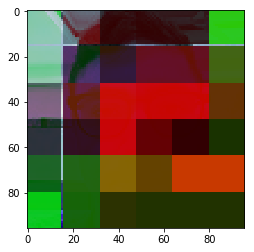

In [91]:
greg_anchor_mat, greg_pos_mat = overlay_difference_colors("images/greg_positive.jpg", "images/greg_anchor.jpg", compare_two_faces("images/greg_positive.jpg", "images/greg_anchor.jpg", 101))
img = Image.fromarray(greg_anchor_mat, 'RGB')
plt.imshow(img)


In [92]:
def iterate_through_layers(positive_image_path, anchor_image_path, num_layers=151):
    
    for i in range(1, num_layers + 1):
        
        difference_matrix = compare_two_faces(positive_image_path, anchor_image_path, i)
        anchor_matrix, positive_matrix = overlay_difference_colors(positive_image_path, anchor_image_path, difference_matrix)
        
        img = Image.fromarray(anchor_matrix)
        plt.figure()
        plt.imshow(img)
        print(FRmodel.layers[i].name)
        plt.show()

zero_padding2d_1


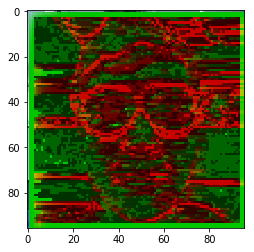

conv1


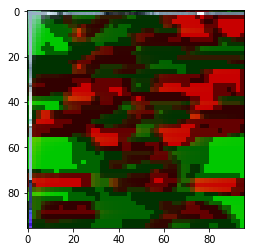

bn1


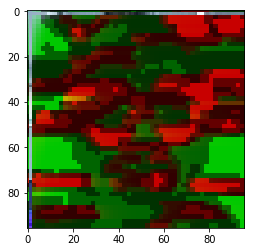

activation_1


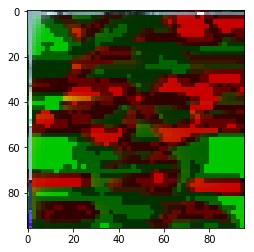

zero_padding2d_2


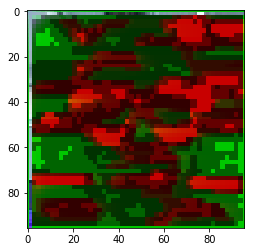

max_pooling2d_1


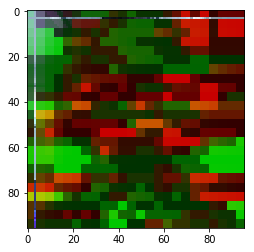

conv2


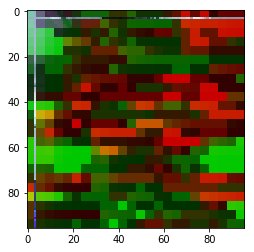

bn2


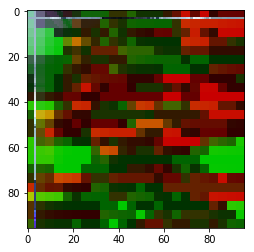

activation_2


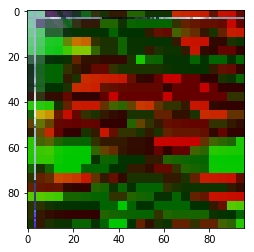

zero_padding2d_3


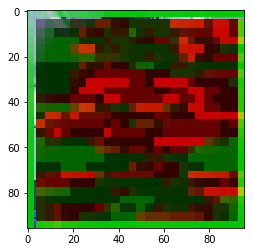

conv3


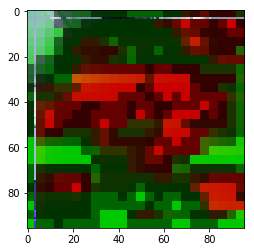

bn3


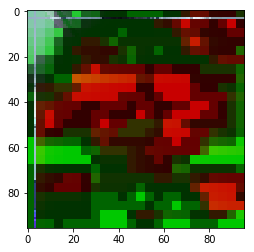

activation_3


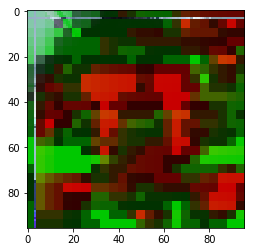

zero_padding2d_4


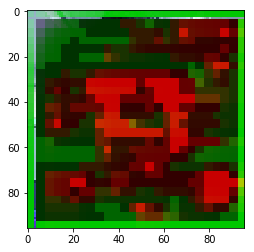

max_pooling2d_2


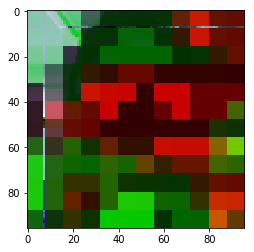

inception_3a_3x3_conv1


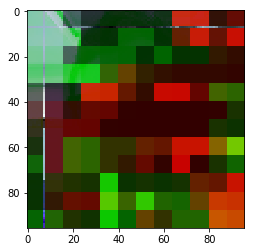

inception_3a_5x5_conv1


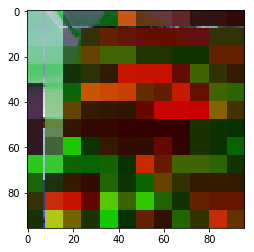

inception_3a_3x3_bn1


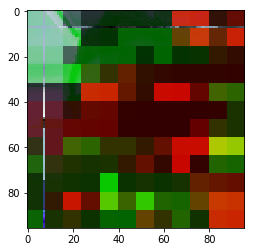

inception_3a_5x5_bn1


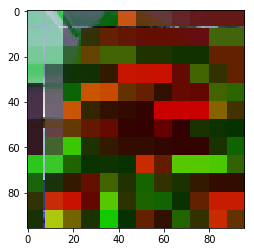

activation_4


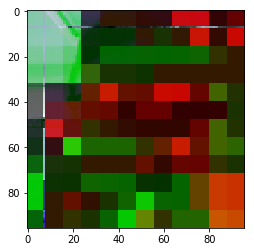

activation_6


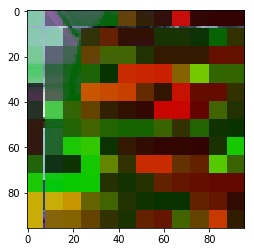

max_pooling2d_3


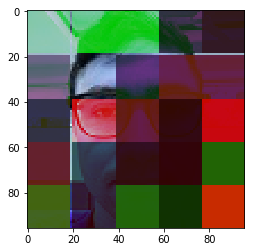

zero_padding2d_5


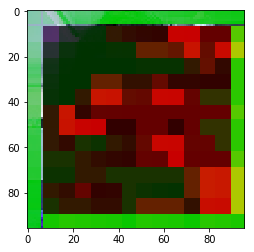

zero_padding2d_6


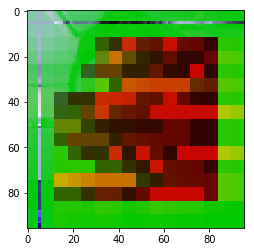

inception_3a_pool_conv


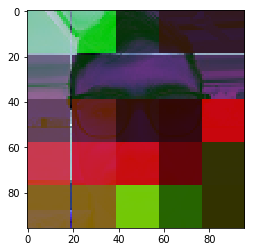

inception_3a_3x3_conv2


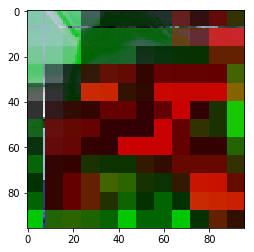

inception_3a_5x5_conv2


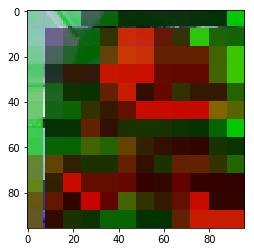

inception_3a_pool_bn


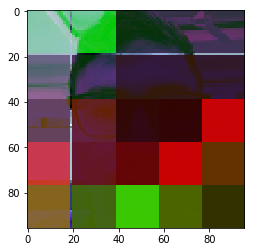

inception_3a_1x1_conv


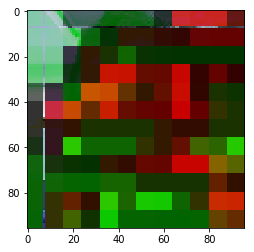

inception_3a_3x3_bn2


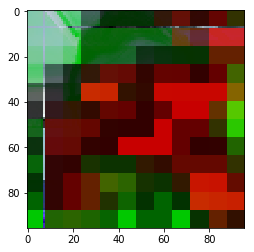

inception_3a_5x5_bn2


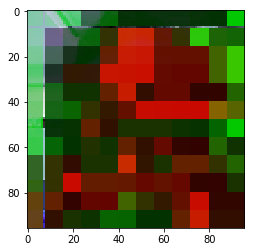

activation_8


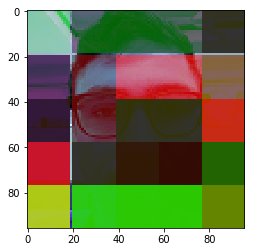

inception_3a_1x1_bn


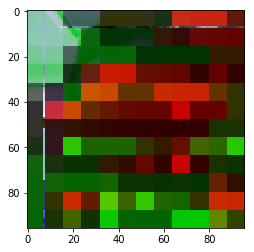

activation_5


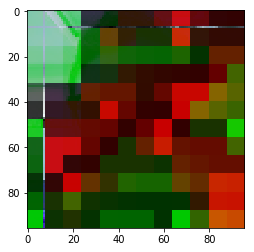

activation_7


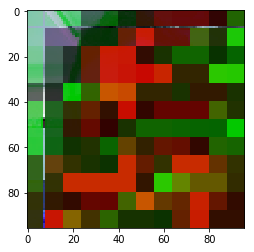

zero_padding2d_7


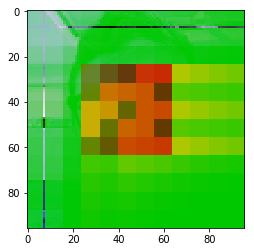

activation_9


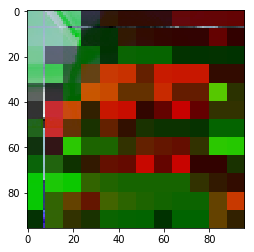

inception_1a


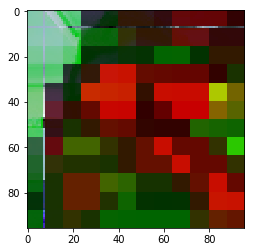

inception_3b_3x3_conv1


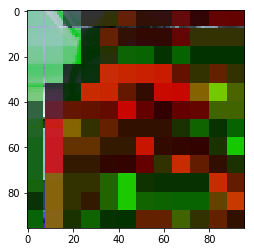

inception_3b_5x5_conv1


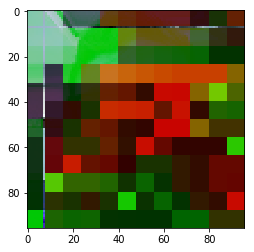

inception_3b_3x3_bn1


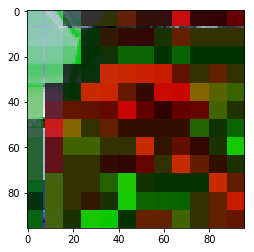

inception_3b_5x5_bn1


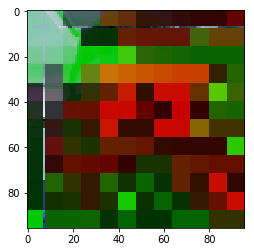

activation_10


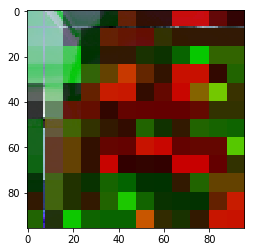

activation_12


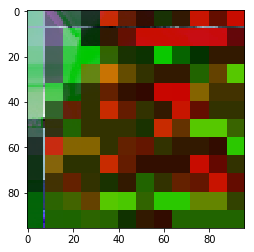

average_pooling2d_1


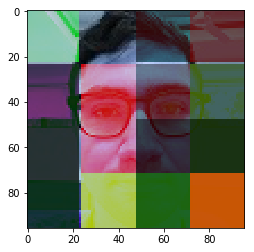

zero_padding2d_8


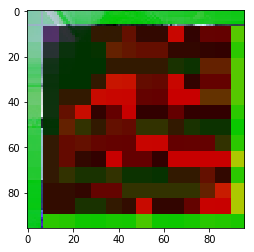

zero_padding2d_9


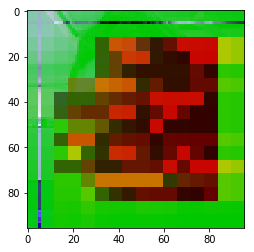

inception_3b_pool_conv


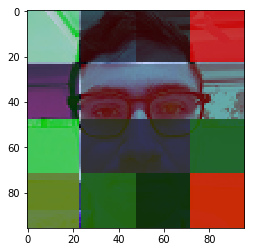

inception_3b_3x3_conv2


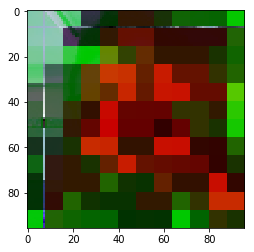

inception_3b_5x5_conv2


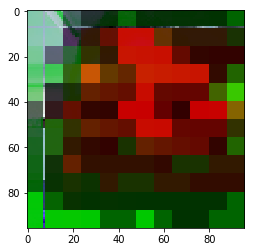

inception_3b_pool_bn


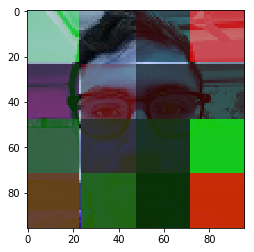

inception_3b_1x1_conv


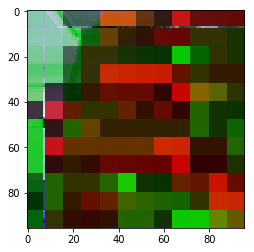

inception_3b_3x3_bn2


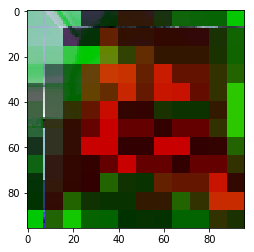

inception_3b_5x5_bn2


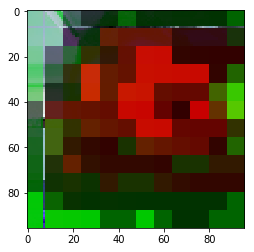

activation_14


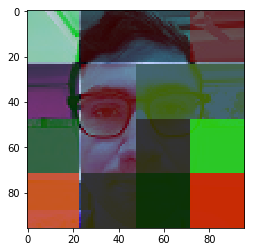

inception_3b_1x1_bn


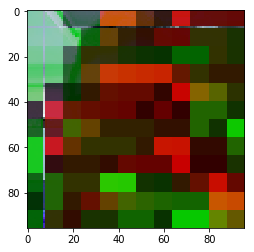

activation_11


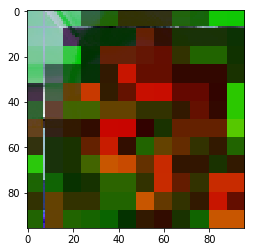

activation_13


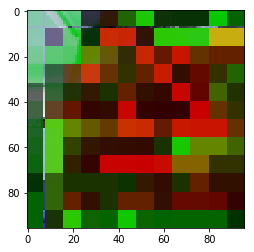

zero_padding2d_10


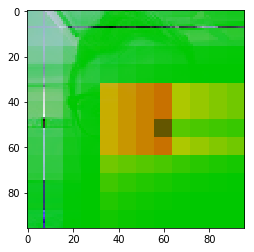

activation_15


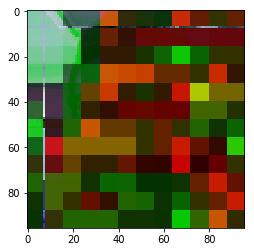

inception_1b


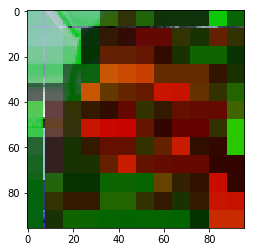

inception_3c_3x3_conv1


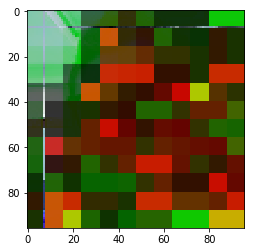

inception_3c_5x5_conv1


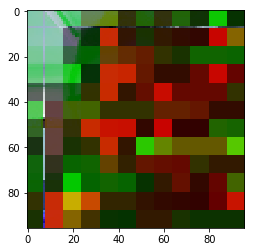

inception_3c_3x3_bn1


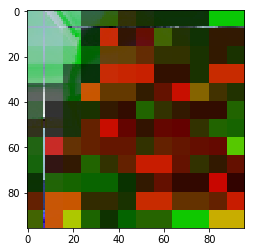

inception_3c_5x5_bn1


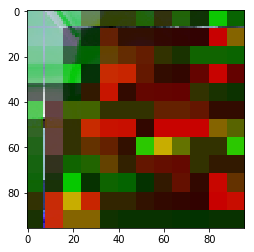

activation_16


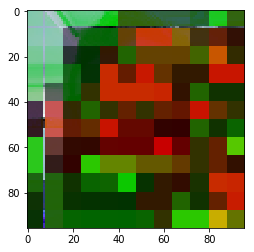

activation_18


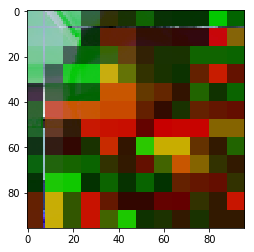

zero_padding2d_11


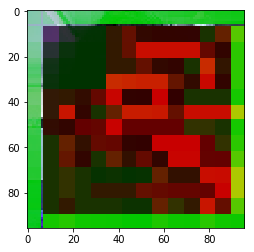

zero_padding2d_12


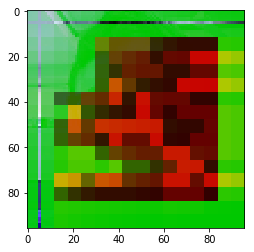

inception_3c_3x3_conv2


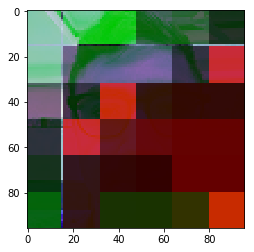

inception_3c_5x5_conv2


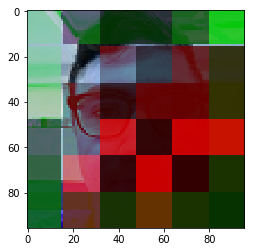

inception_3c_3x3_bn2


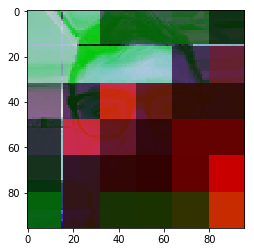

inception_3c_5x5_bn2


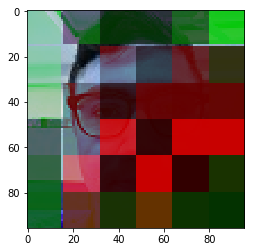

max_pooling2d_4


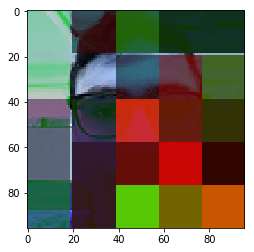

activation_17


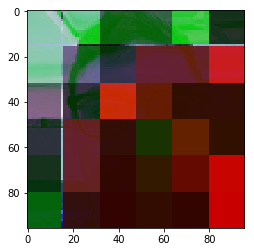

activation_19


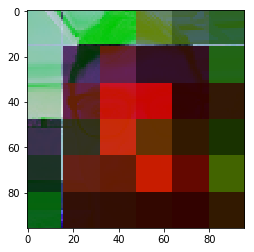

zero_padding2d_13


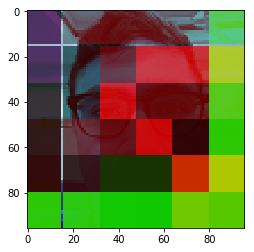

inception_1c


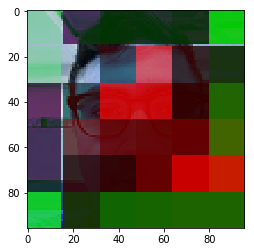

inception_4a_3x3_conv1


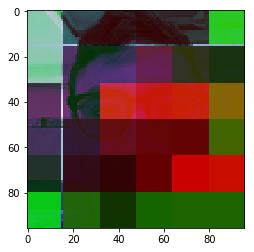

inception_4a_5x5_conv1


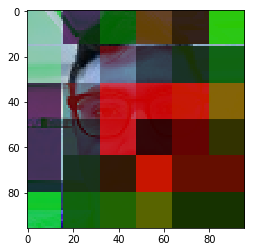

inception_4a_3x3_bn1


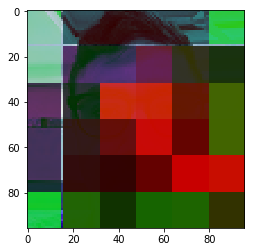

inception_4a_5x5_bn1


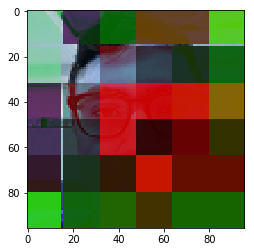

activation_20


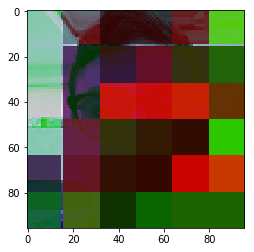

activation_22


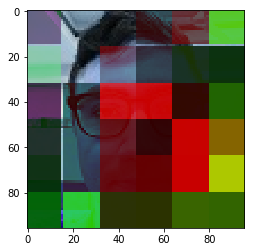

average_pooling2d_2


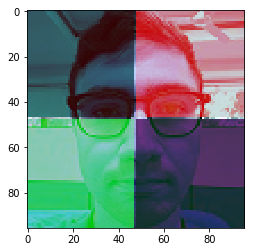

zero_padding2d_14


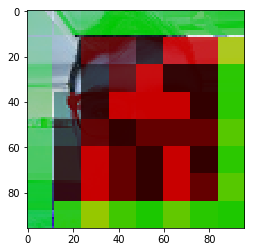

zero_padding2d_15


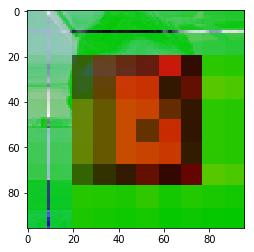

inception_4a_pool_conv


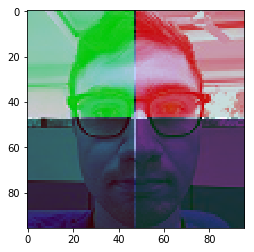

inception_4a_3x3_conv2


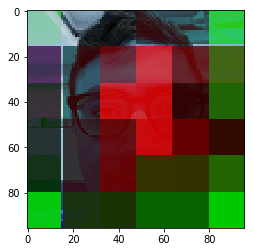

inception_4a_5x5_conv2


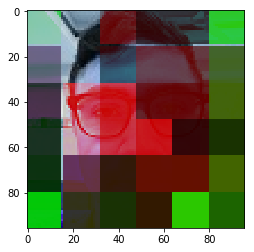

inception_4a_pool_bn


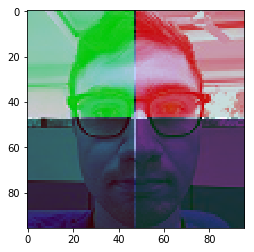

inception_4a_1x1_conv


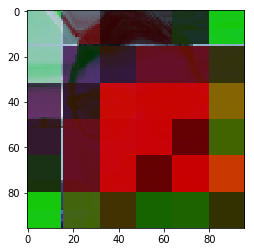

inception_4a_3x3_bn2


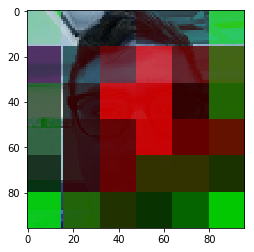

inception_4a_5x5_bn2


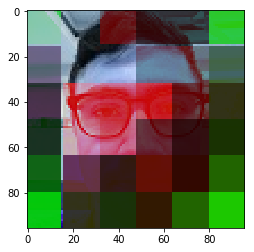

activation_24


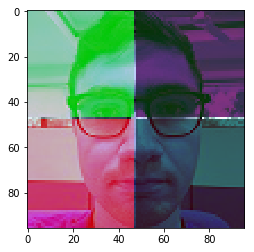

inception_4a_1x1_bn


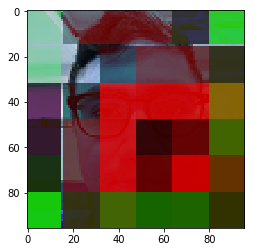

activation_21


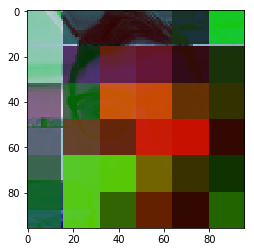

activation_23


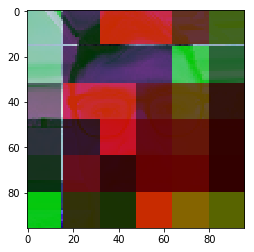

zero_padding2d_16


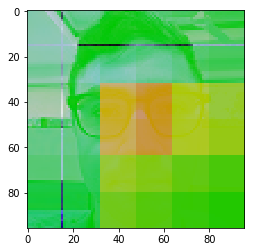

activation_25


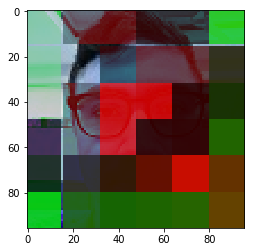

inception_2a


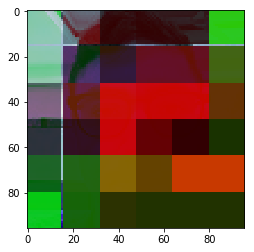

inception_4e_3x3_conv1


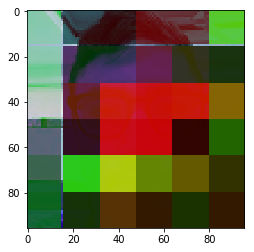

inception_4e_5x5_conv1


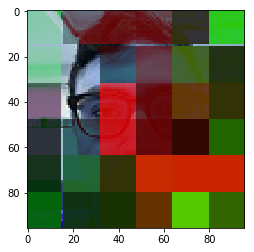

inception_4e_3x3_bn1


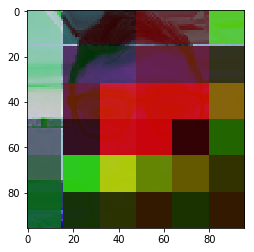

inception_4e_5x5_bn1


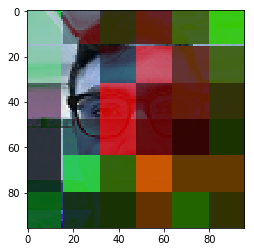

activation_26


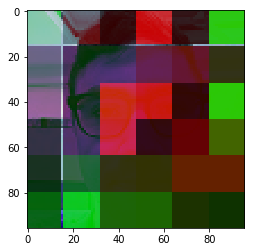

activation_28


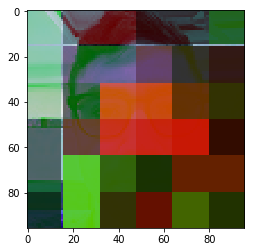

zero_padding2d_17


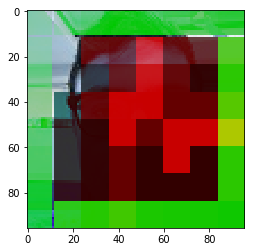

zero_padding2d_18


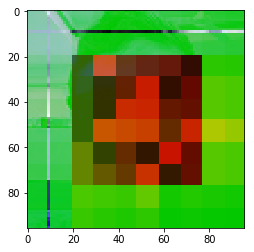

inception_4e_3x3_conv2


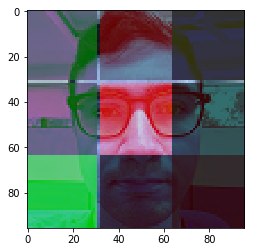

inception_4e_5x5_conv2


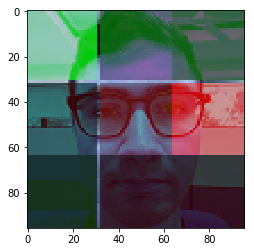

inception_4e_3x3_bn2


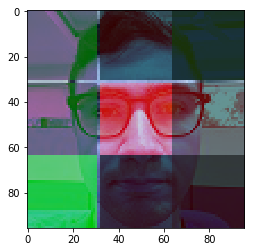

inception_4e_5x5_bn2


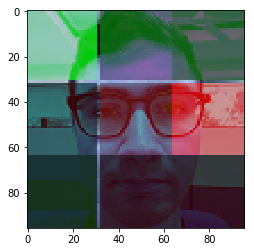

max_pooling2d_5


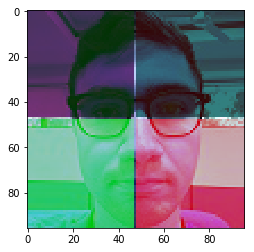

activation_27


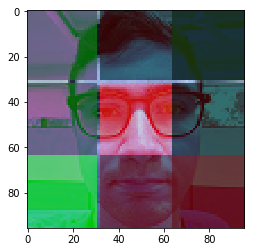

activation_29


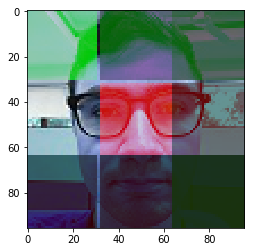

zero_padding2d_19


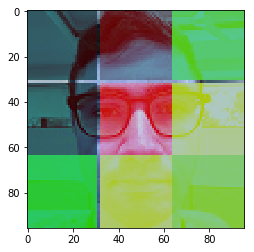

inception_2b


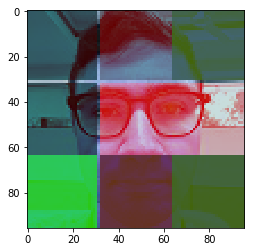

inception_5a_3x3_conv1


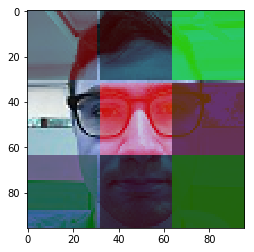

inception_5a_3x3_bn1


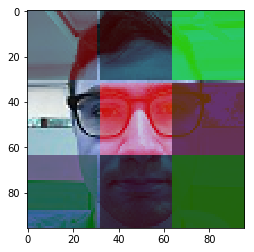

activation_30


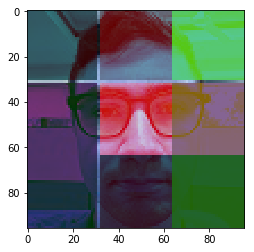

average_pooling2d_3


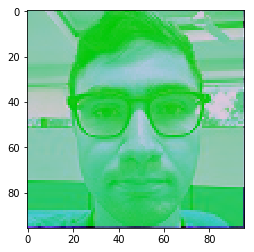

zero_padding2d_20


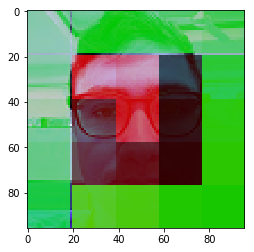

inception_5a_pool_conv


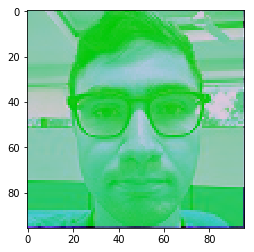

inception_5a_3x3_conv2


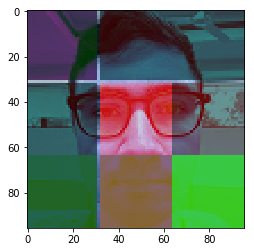

inception_5a_pool_bn


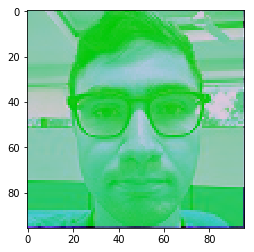

inception_5a_1x1_conv


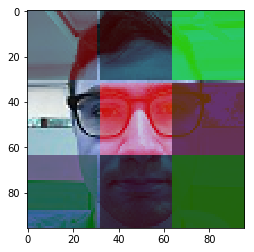

inception_5a_3x3_bn2


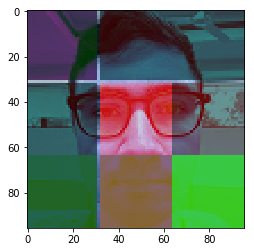

activation_32


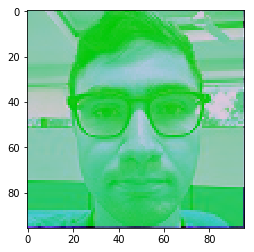

inception_5a_1x1_bn


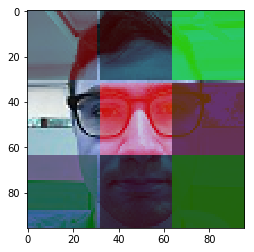

activation_31


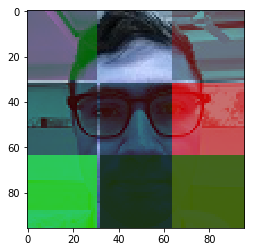

zero_padding2d_21


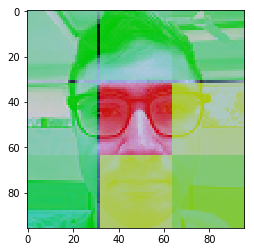

activation_33


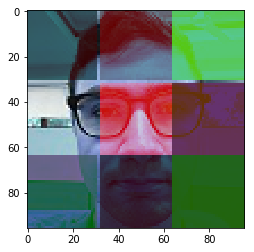

inception_3a


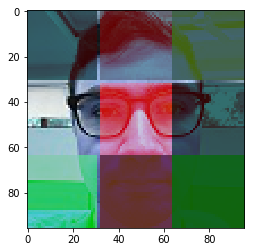

inception_5b_3x3_conv1


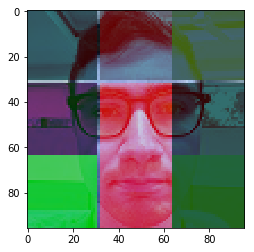

inception_5b_3x3_bn1


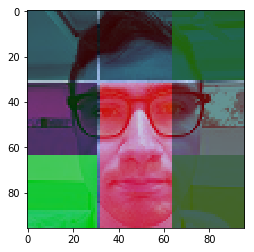

activation_34


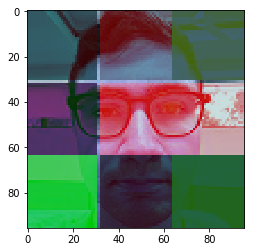

max_pooling2d_6


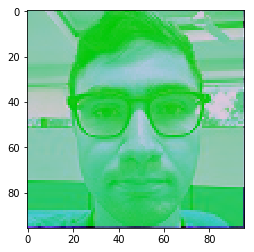

zero_padding2d_22


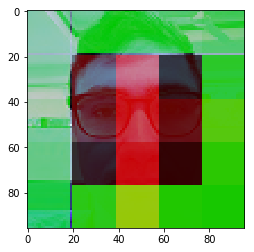

inception_5b_pool_conv


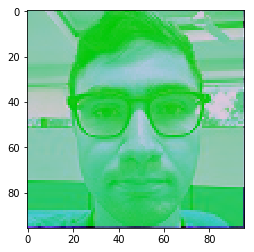

inception_5b_3x3_conv2


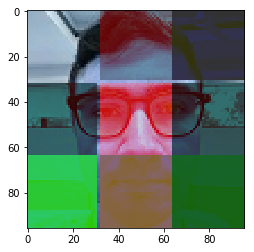

inception_5b_pool_bn


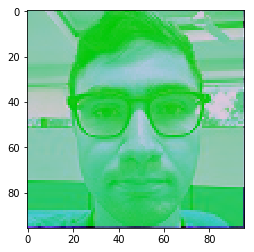

inception_5b_1x1_conv


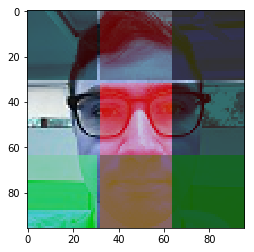

inception_5b_3x3_bn2


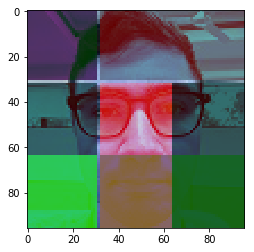

activation_36


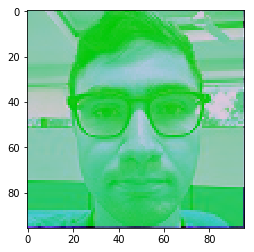

inception_5b_1x1_bn


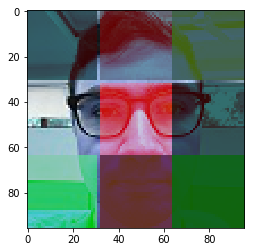

activation_35


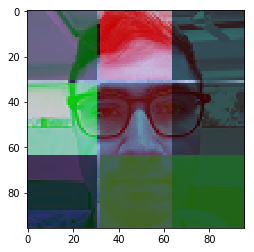

zero_padding2d_23


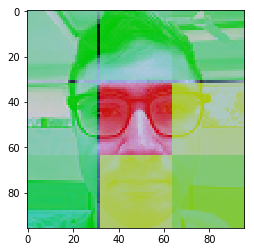

activation_37


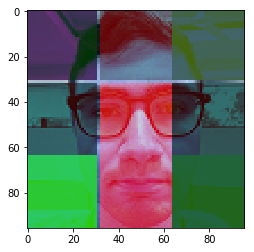

inception_3b


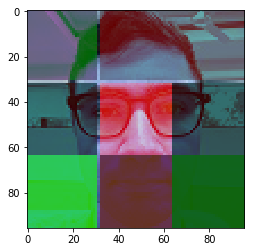

average_pooling2d_4


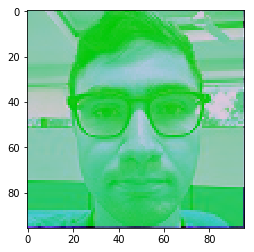

In [93]:
iterate_through_layers("images/greg_positive.jpg", "images/greg_anchor.jpg")

zero_padding2d_1


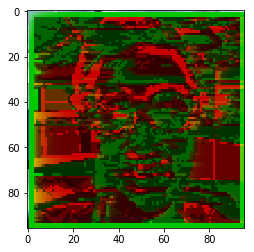

conv1


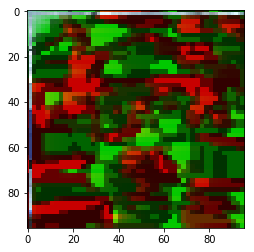

bn1


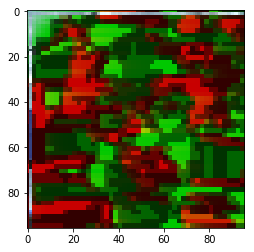

activation_1


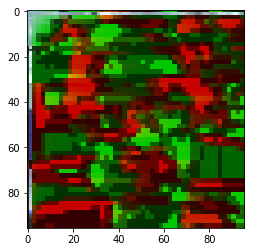

zero_padding2d_2


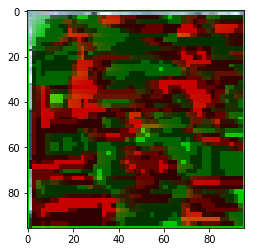

max_pooling2d_1


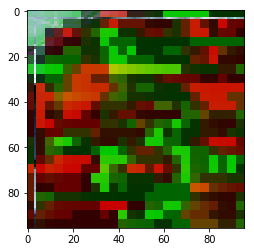

conv2


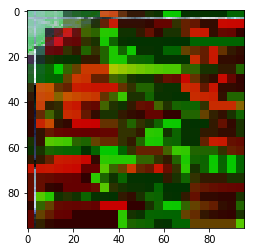

bn2


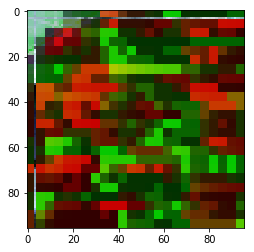

activation_2


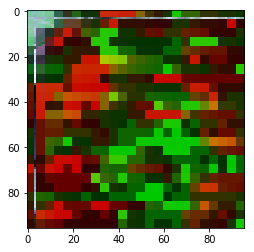

zero_padding2d_3


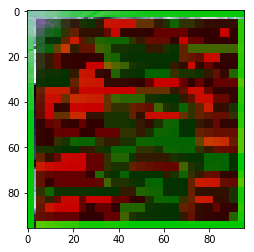

conv3


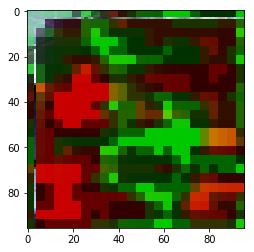

bn3


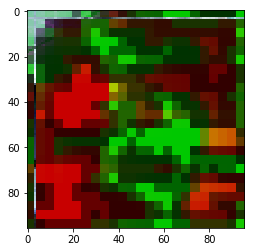

activation_3


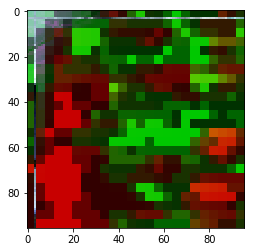

zero_padding2d_4


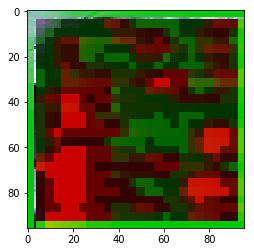

max_pooling2d_2


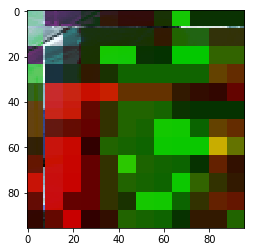

inception_3a_3x3_conv1


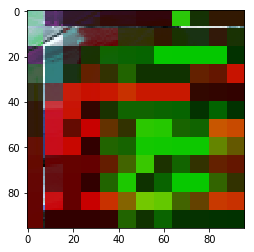

inception_3a_5x5_conv1


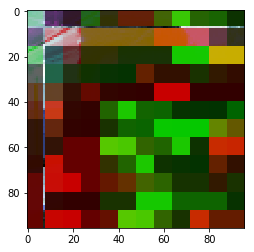

inception_3a_3x3_bn1


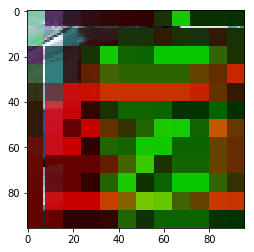

inception_3a_5x5_bn1


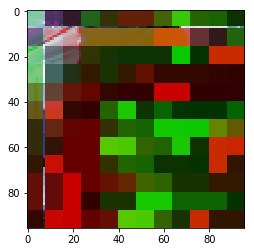

activation_4


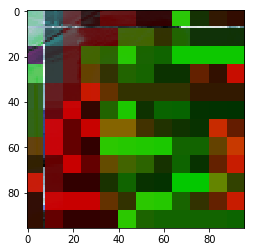

activation_6


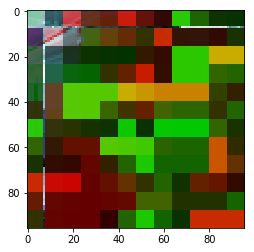

max_pooling2d_3


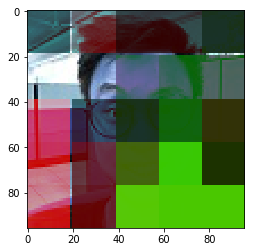

zero_padding2d_5


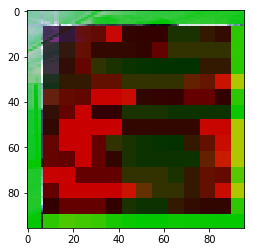

zero_padding2d_6


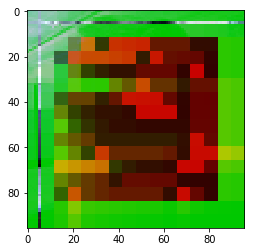

inception_3a_pool_conv


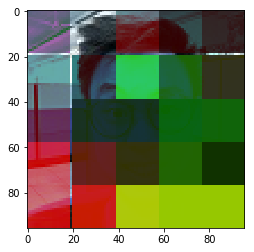

inception_3a_3x3_conv2


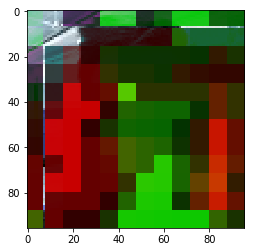

inception_3a_5x5_conv2


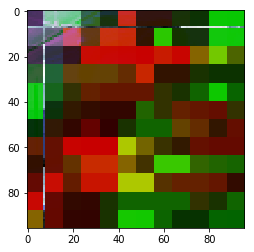

inception_3a_pool_bn


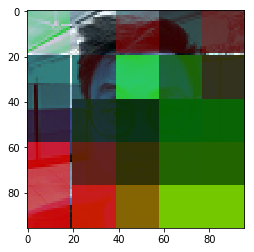

inception_3a_1x1_conv


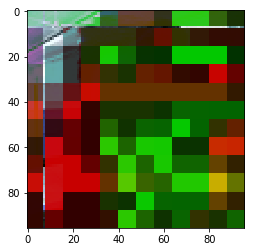

inception_3a_3x3_bn2


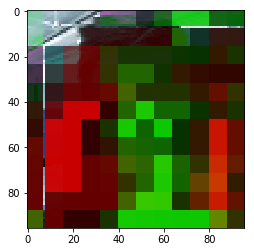

inception_3a_5x5_bn2


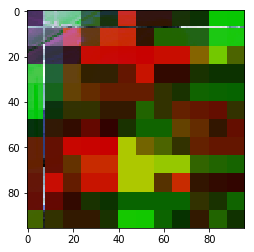

activation_8


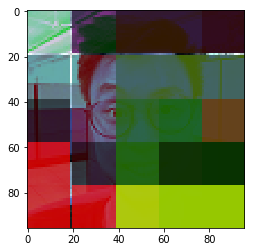

inception_3a_1x1_bn


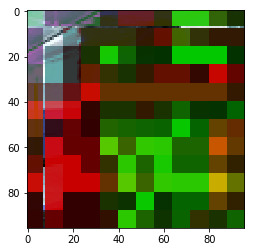

activation_5


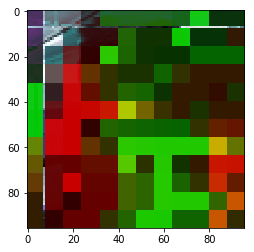

activation_7


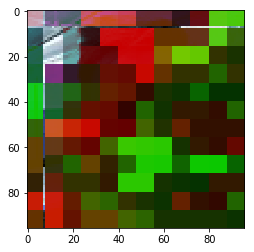

zero_padding2d_7


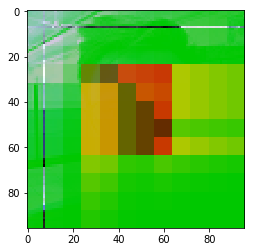

activation_9


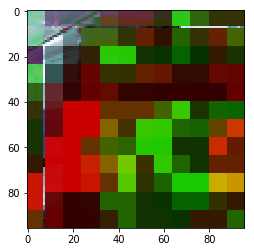

inception_1a


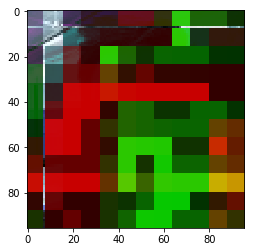

inception_3b_3x3_conv1


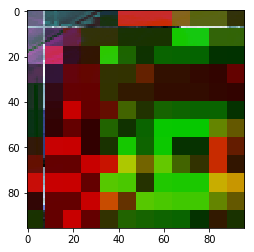

inception_3b_5x5_conv1


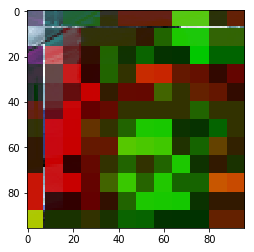

inception_3b_3x3_bn1


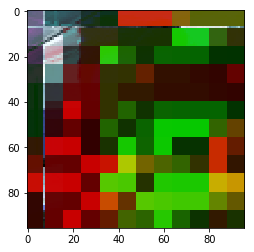

inception_3b_5x5_bn1


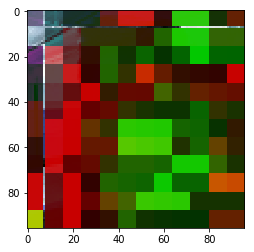

activation_10


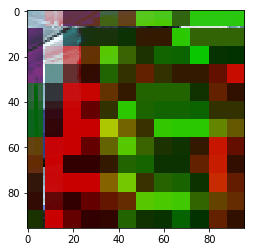

activation_12


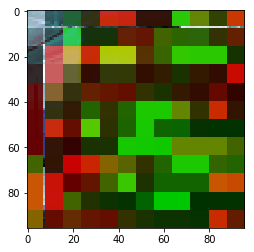

average_pooling2d_1


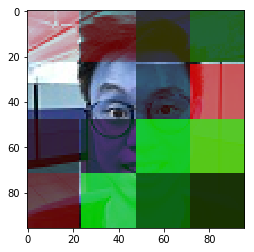

zero_padding2d_8


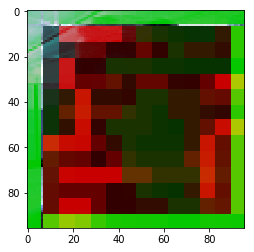

zero_padding2d_9


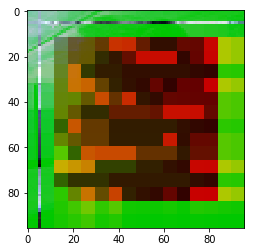

inception_3b_pool_conv


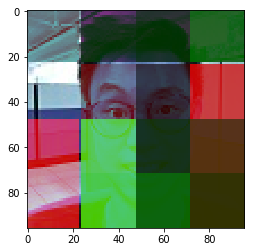

inception_3b_3x3_conv2


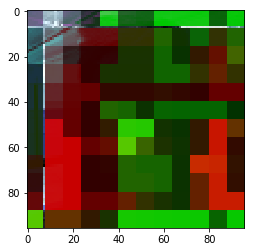

inception_3b_5x5_conv2


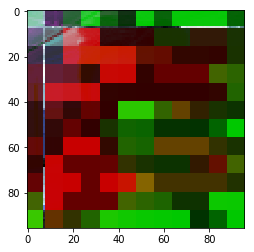

inception_3b_pool_bn


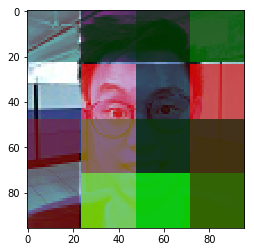

inception_3b_1x1_conv


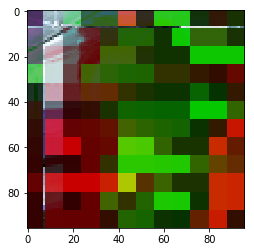

inception_3b_3x3_bn2


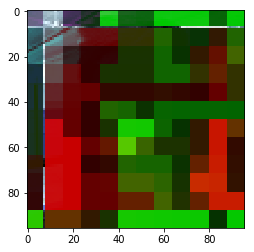

inception_3b_5x5_bn2


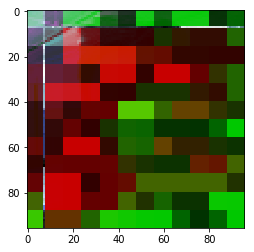

activation_14


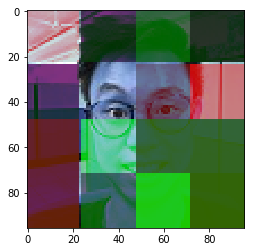

inception_3b_1x1_bn


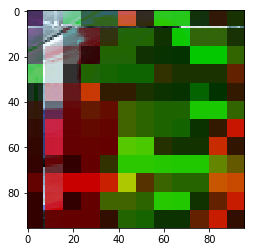

activation_11


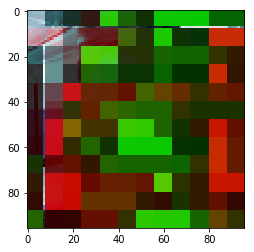

activation_13


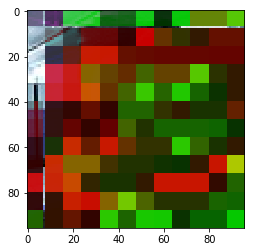

zero_padding2d_10


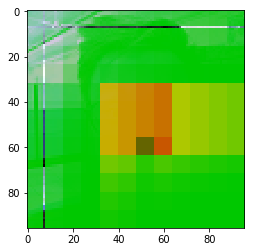

activation_15


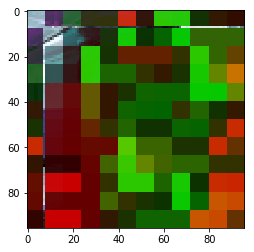

inception_1b


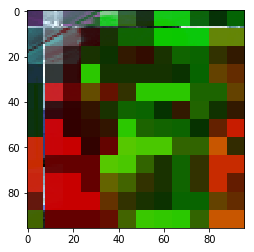

inception_3c_3x3_conv1


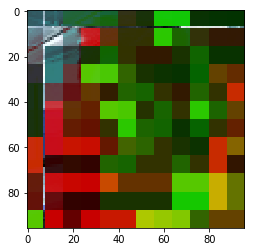

inception_3c_5x5_conv1


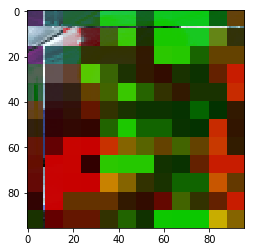

inception_3c_3x3_bn1


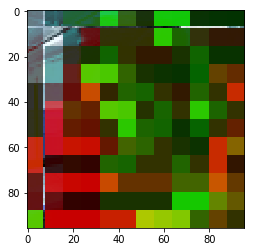

inception_3c_5x5_bn1


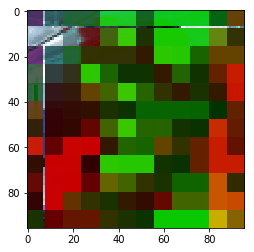

activation_16


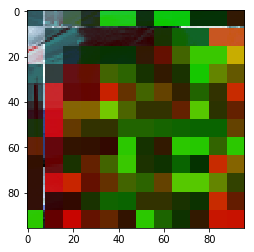

activation_18


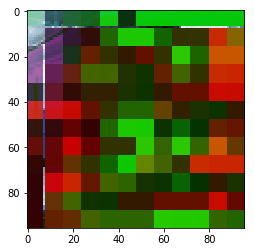

zero_padding2d_11


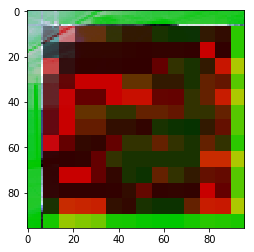

zero_padding2d_12


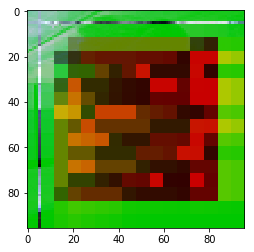

inception_3c_3x3_conv2


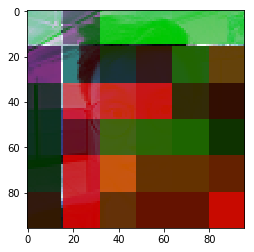

inception_3c_5x5_conv2


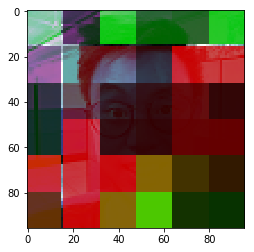

inception_3c_3x3_bn2


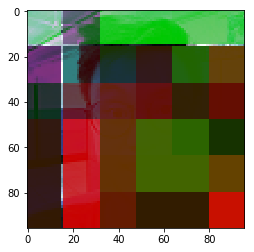

inception_3c_5x5_bn2


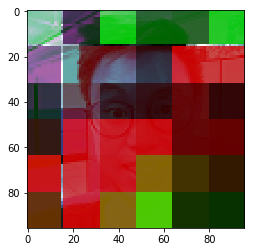

max_pooling2d_4


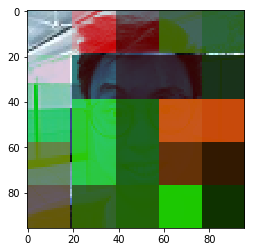

activation_17


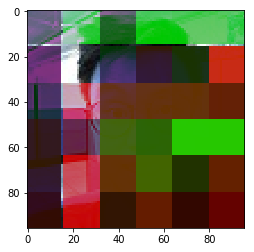

activation_19


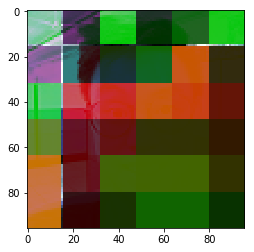

zero_padding2d_13


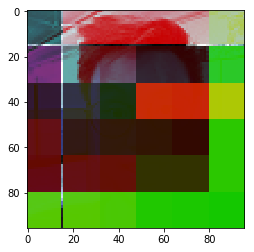

inception_1c


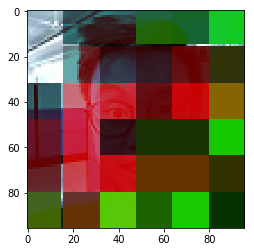

inception_4a_3x3_conv1


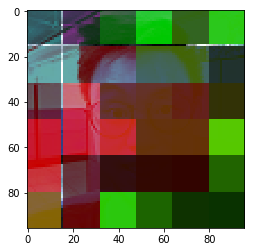

inception_4a_5x5_conv1


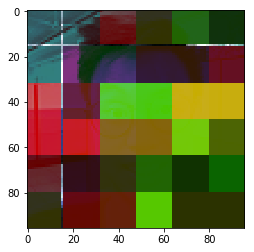

inception_4a_3x3_bn1


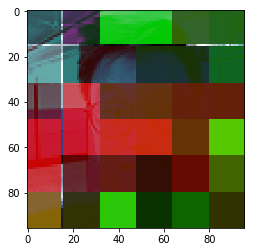

inception_4a_5x5_bn1


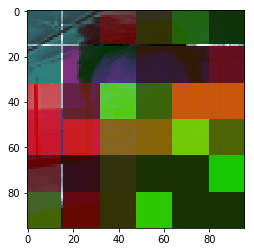

activation_20


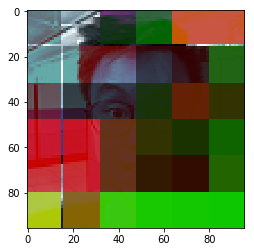

activation_22


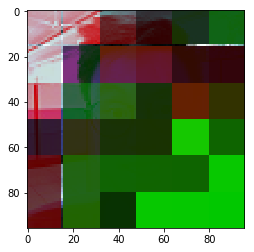

average_pooling2d_2


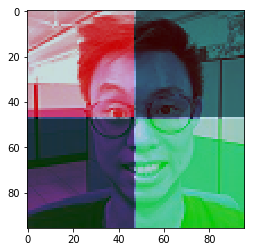

zero_padding2d_14


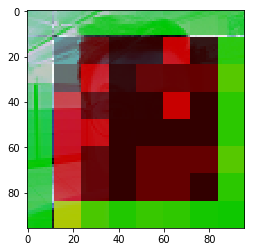

zero_padding2d_15


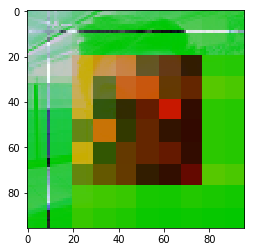

inception_4a_pool_conv


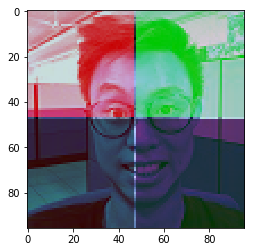

inception_4a_3x3_conv2


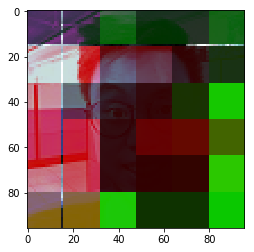

inception_4a_5x5_conv2


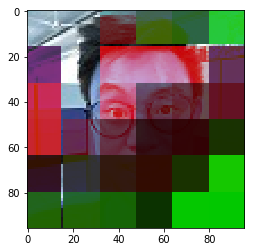

inception_4a_pool_bn


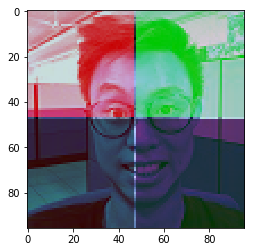

inception_4a_1x1_conv


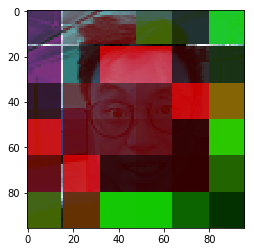

inception_4a_3x3_bn2


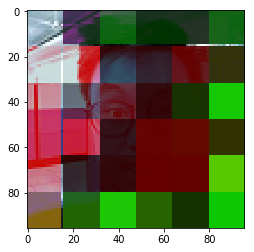

inception_4a_5x5_bn2


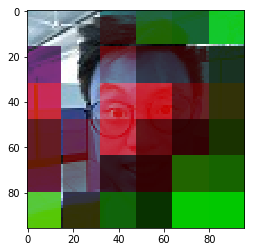

activation_24


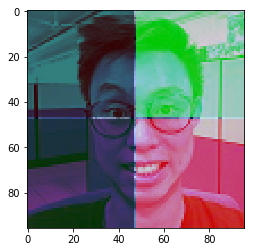

inception_4a_1x1_bn


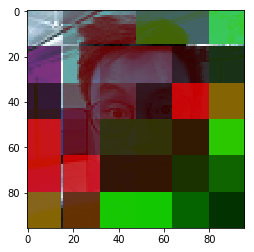

activation_21


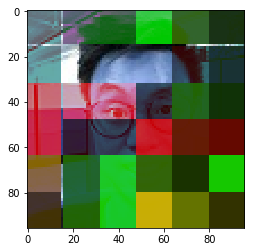

activation_23


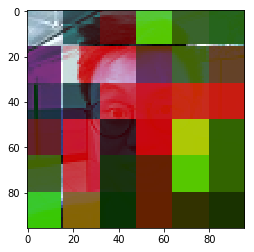

zero_padding2d_16


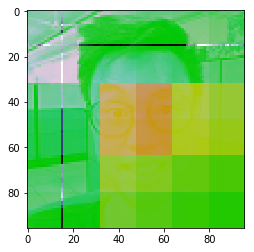

activation_25


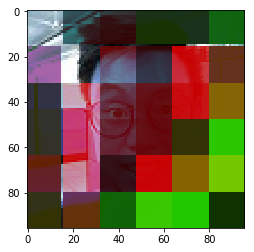

inception_2a


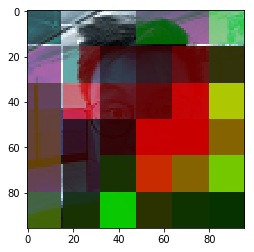

inception_4e_3x3_conv1


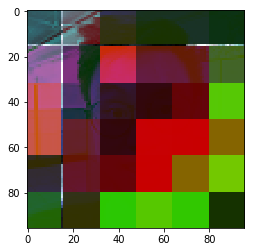

inception_4e_5x5_conv1


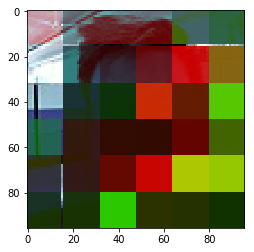

inception_4e_3x3_bn1


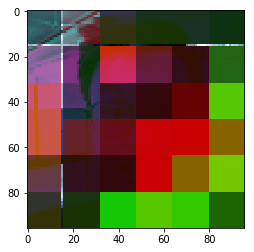

inception_4e_5x5_bn1


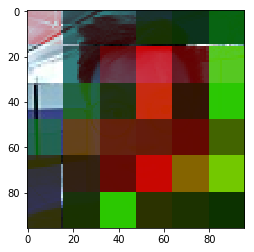

activation_26


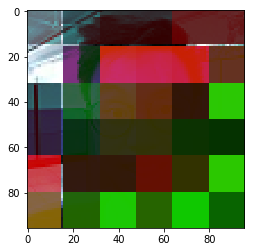

activation_28


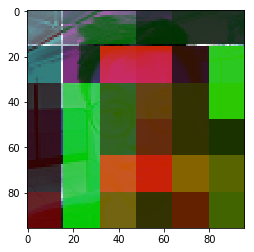

zero_padding2d_17


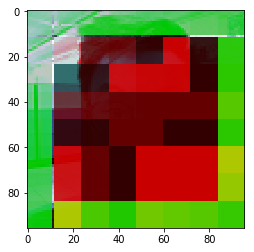

zero_padding2d_18


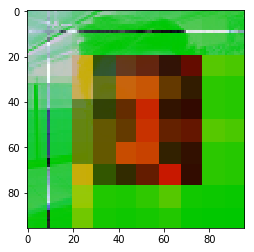

inception_4e_3x3_conv2


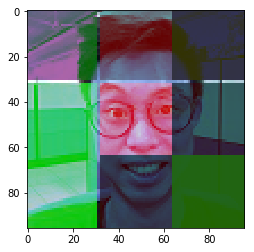

inception_4e_5x5_conv2


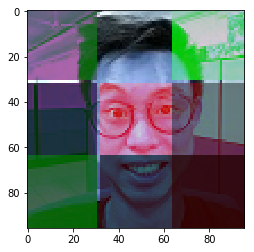

inception_4e_3x3_bn2


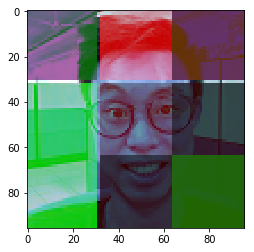

inception_4e_5x5_bn2


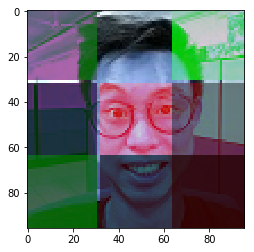

max_pooling2d_5


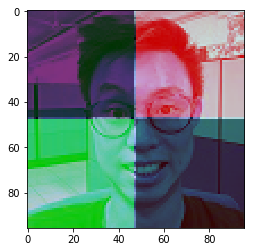

activation_27


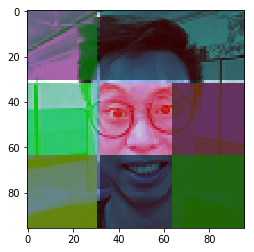

activation_29


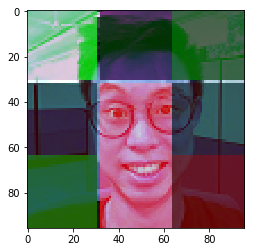

zero_padding2d_19


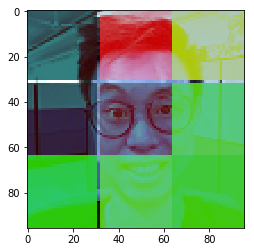

inception_2b


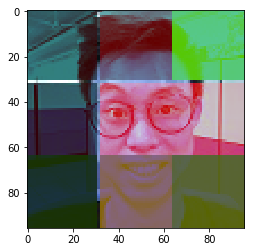

inception_5a_3x3_conv1


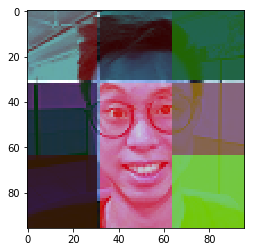

inception_5a_3x3_bn1


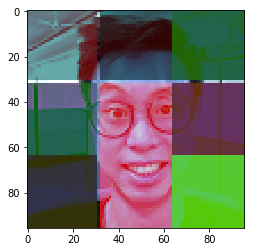

activation_30


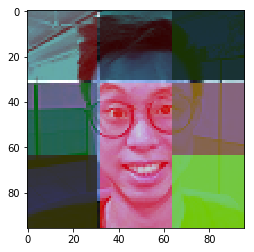

average_pooling2d_3


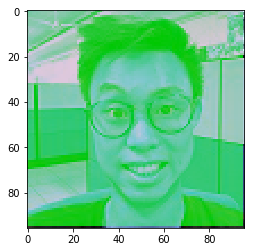

zero_padding2d_20


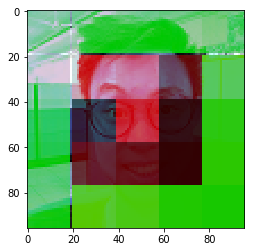

inception_5a_pool_conv


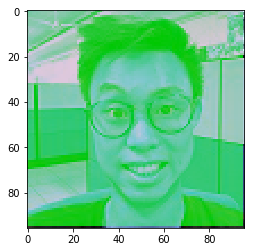

inception_5a_3x3_conv2


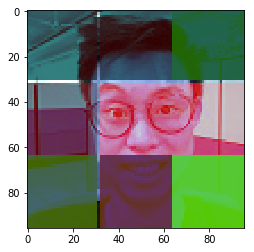

inception_5a_pool_bn


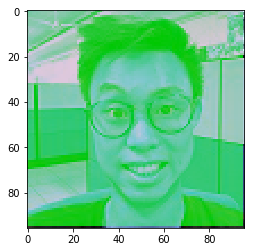

inception_5a_1x1_conv


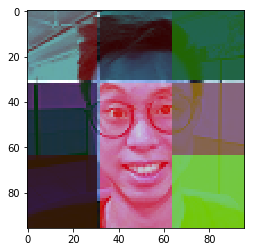

inception_5a_3x3_bn2


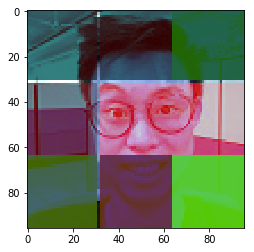

activation_32


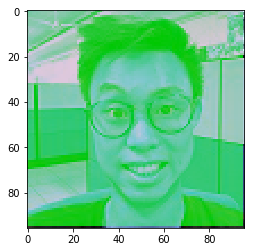

inception_5a_1x1_bn


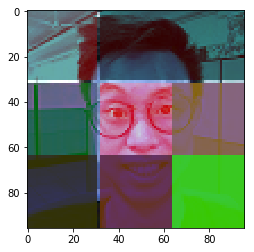

activation_31


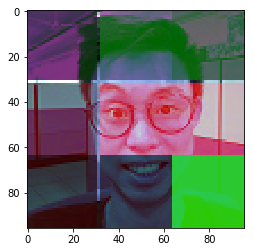

zero_padding2d_21


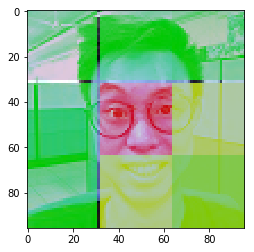

activation_33


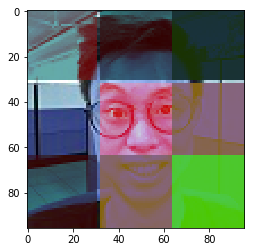

inception_3a


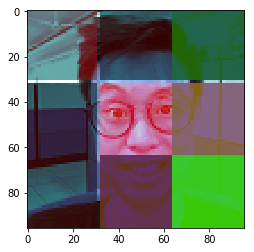

inception_5b_3x3_conv1


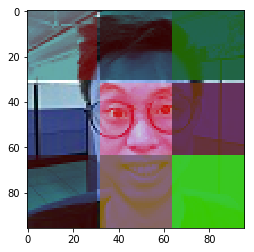

inception_5b_3x3_bn1


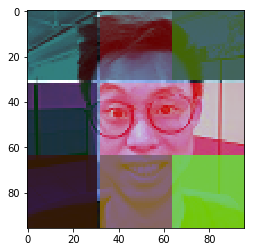

activation_34


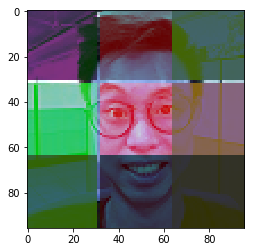

max_pooling2d_6


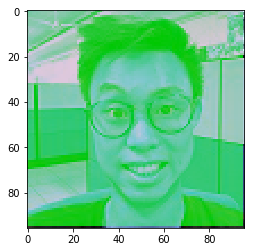

zero_padding2d_22


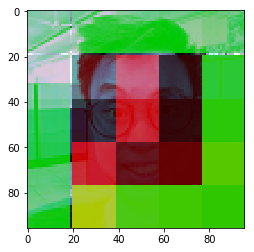

inception_5b_pool_conv


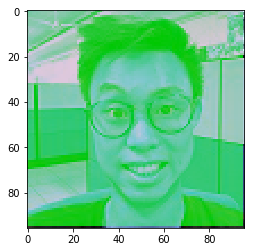

inception_5b_3x3_conv2


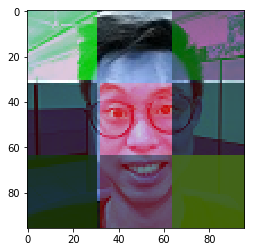

inception_5b_pool_bn


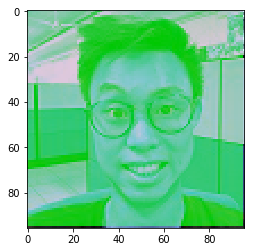

inception_5b_1x1_conv


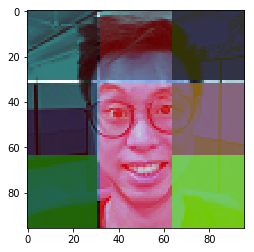

inception_5b_3x3_bn2


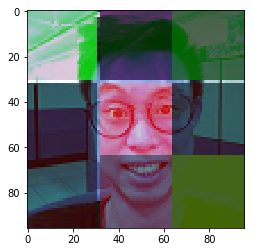

activation_36


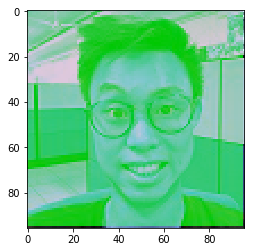

inception_5b_1x1_bn


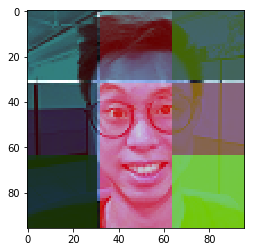

activation_35


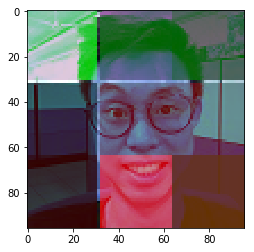

zero_padding2d_23


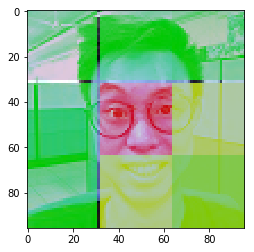

activation_37


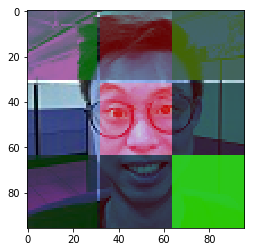

inception_3b


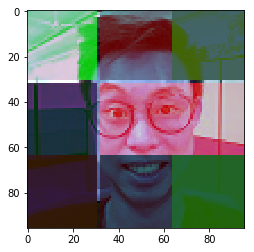

average_pooling2d_4


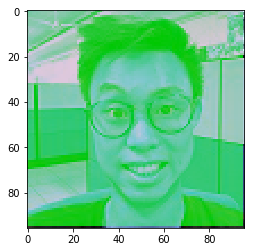

In [94]:
iterate_through_layers("images/greg_positive.jpg", "images/maxim_anchor.jpg")